# Identify Engagement Profile

## Step 4 - Identify Engagement Profile
In this step, the specified K-means analysis described in `Step 3` is implemented. Here is the code for how the cluster analysis was performed to determine the number of groups using the indicator variables. Below are the stages to implement this analysis. 

#### 1 - Load Relevant Packages

In [1]:
invisible({ # Hide Package Loadings

    # ---- Packages for Data Management
    library(haven) # Read In Stata Files
    library(dplyr)
    library(foreign)
    library(naniar) # Missing Data

    # ---- Additional Packages for Cluster analysis
    library(factoextra)
    library(naniar)
    library(plotly)
    library(cluster)
    library(fpc)
    library(patchwork)  # For combining ggplots
})

Warning message:
"package 'dplyr' was built under R version 4.4.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Warning message:
"package 'patchwork' was built under R version 4.4.3"


### 2 - Import the data
The data for the COPe-Support arm is imported, and scaled as magnitude has a big influence on the clustering. For individuals with a single missing value these are replaced by the mean for that variable. 

In [2]:
# Import Data
source("Folders.R") # Load Folder String Paths
setwd(Derived) # Change to Folder String called Derived

cope.data <- read_dta("COPE_Final_Indicators.dta") 

# Converting categorical variables to factors
fnames <- c("cohort", "registered", "activated")
cope.data <- cope.data %>% mutate_at(vars(fnames), as.factor)

# Tidy up missing data in one variable for two people - use mean imputation
cope.data <- cope.data %>%
  mutate(totaldays = if_else(ID == 166 & is.na(totaldays), 
                             mean(totaldays, na.rm = TRUE), 
                             totaldays)) -> cope.data

# Now same thing but for multiple variables for one person
cope.data <- cope.data %>%
  mutate_at(vars(loginwks, pageviews, dur_wkpv, rate_wkpv, posts, act_wkpv), 
            ~if_else(is.na(.) & ID == 283, mean(., na.rm = TRUE), .)) -> cope.data

# Must be numeric, drop other variables not indicator variables
dropnames <- c("ID", "cohort", "posts", "act_wkpv", "act_ptp", "act_ate", "complete")
cope.final <- cope.data[,!(names(cope.data) %in% dropnames)]
cope.final <- cope.final %>% mutate_at(vars(c("registered", "activated")), as.numeric)

# Subset to Complete Case (known issue with logindays)
cope.final <- cope.final[complete.cases(cope.final),]
scaled <- scale(cope.final)

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(fnames)

  # Now:
  data %>% select(all_of(fnames))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


In [3]:
head(scaled)

registered,activated,totalmins,logindays,loginwks,pageviews,ptp,ate,totaldays,dur_wkpv,dur_ptp,dur_ate,sdwkpv,sdptp,sdate,rate_wkpv,rate_ptp,rate_ate
0.5048068,0.5157236,-0.46664906,-0.5359297,-0.7077796,-0.57973059,-0.371331857,-0.4136820,-0.7520096,-0.8849915,-0.33650059,-0.4017578,-0.69780160,-0.3997715,-0.4328030,1.1638049,-0.4698263,-0.5079972
0.5048068,0.5157236,-0.46153382,-0.5359297,-0.7077796,-0.57278040,-0.371331857,-0.4136820,-0.9236558,-0.8849915,-0.33650059,-0.4017578,-0.67768759,-0.3997715,-0.4328030,1.1638049,-0.4698263,-0.5079972
0.5048068,0.5157236,0.16488627,1.0922994,1.6038276,0.35159534,-0.371331857,1.0697231,0.8786289,1.0097800,-0.33650059,2.5444659,0.35476779,-0.3997715,1.1132522,0.7880942,-0.4698263,0.3176518
0.5048068,0.5157236,0.29849457,0.8091292,1.1835354,0.86127620,1.511851131,0.4763611,0.8357173,1.0097800,1.11147163,-0.1339193,0.31201587,1.7353558,1.2010403,0.4123836,1.2993173,2.5193824
0.5048068,0.5157236,0.97825305,0.3843737,1.1835354,0.10138837,0.758577936,4.0365332,1.1790097,1.3012833,3.71782162,3.3479815,0.01710502,0.6891761,3.2205819,0.1775644,0.1620107,0.5732099
0.5048068,0.5157236,0.08304244,0.3135812,0.7632432,-0.01908165,0.005304741,-0.1170010,1.1790097,1.4470349,-0.04690614,-0.1339193,-0.02389157,0.2695353,0.1118115,-0.2285346,2.4787462,2.5193824


### 3 - Choose Best K Value
Initially, to find the best value of K the range (2 to 10) is iterated through. The K-means cluster is applied then the average Silhouette score is calculated. The final K taken forward will be the one with the highest mean value. This will then be assessed visually to ensure the Silhouette scores for individual observations across the groups is also reasonable (i.e. few negative values and group widths are reasonable).

[1] 4

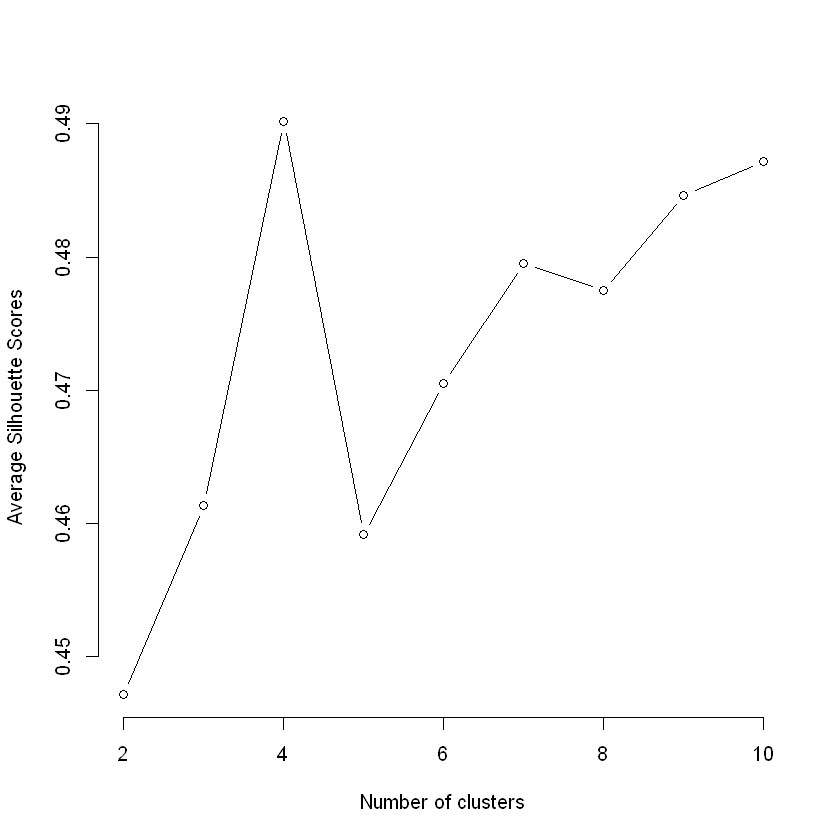

In [4]:
# -------------------------------------------------------
# ---------- Set Function to Choose K
# -------------------------------------------------------

silhouette_score <- function(k, data=scaled){
  km <- kmeans(data, centers = k, iter.max = 1000, nstart = 100)
  ss <- silhouette(km$cluster, dist(data))
  mean(ss[, 3])
}

k <- 2:10 # Specified Range of K

# -------------------------------------------------------
# ---------- Loop through K to find best
# -------------------------------------------------------

avg_sil <- sapply(k, silhouette_score)
par(bg = "white")  # Set background to white
plot(k, type='b', avg_sil, xlab='Number of clusters', ylab='Average Silhouette Scores', frame=FALSE)
final_k = which.max(avg_sil) + 1
final_k ## Optimal is 4 clusters

### 3 - Run K-Means
With the final value of K selected, which is 4, this is then entered again into the K-means cluster algorithm to generate all the additional checks. This includes checking the number in each group and the means across the groups as well. 

In [5]:
km.res = kmeans(scaled, centers=final_k, iter.max = 1000, nstart = 100)
km.res$cluster
km.res$size
km.res$centers

[1] 1 1 3 3 2 3 1 4 2 4 1 4 4 1 4 1 1 1 1 4 1 3 4 3 4 1 1 1 1 3 3 4 4 2 1 2 4
 [38] 1 1 4 4 1 1 2 1 1 3 1 1 4 3 3 1 2 1 1 1 1 1 1 3 3 1 1 4 1 1 1 3 1 4 4 3 1
 [75] 1 3 1 4 3 2 4 1 1 3 1 1 4 1 3 1 4 1 3 2 4 1 3 3 4 3 1 3 4 1 1 1 1 1 3 4 1
[112] 1 2 3 3 1 3 1 1 1 1 4 3 3 3 1 1 4 1 3 1 3 2 4 3 1 4 1 1 4 1 1

[1] 69 10 33 30

,registered,activated,totalmins,logindays,loginwks,pageviews,ptp,ate,totaldays,dur_wkpv,dur_ptp,dur_ate,sdwkpv,sdptp,sdate,rate_wkpv,rate_ptp,rate_ate
1,0.5048068,0.5157236,-0.3357824,-0.3810068,-0.3841513,-0.3425988,-0.3440393,-0.4093823,-0.1770572,-0.274077,-0.3197125,-0.3978761,-0.2757998,-0.3573627,-0.4249100,0.4055094,-0.3416275,-0.4641221
2,0.5048068,0.5157236,1.9066734,2.4019620,1.8139738,2.3222069,2.7924156,2.7311368,1.1468260,1.272133,2.7911194,2.2230597,2.0213291,2.5818126,2.6809023,0.6336696,1.1388564,1.1743503
3,0.5048068,0.5157236,0.5556913,0.6203490,1.0880145,0.5417779,0.2107429,0.4044384,1.0574270,1.124615,0.1286056,0.5235026,0.6046085,0.3282741,0.4695109,0.2929773,0.7963187,1.0763890
4,-1.8846119,-1.9253681,-0.4745187,-0.6067222,-0.9179258,-0.5820473,-0.3713319,-0.4136820,-1.1382135,-1.030743,-0.3365006,-0.4017578,-0.7045063,-0.3997715,-0.4328030,-1.4661697,-0.4698263,-0.5079972


### 4 - Visualise SIlhouette Score
To ensure the selection of the final K is reasonable, the Silhouette plot is produced. Should this identify any issues or look unreasonable then the K with the next highest average Silhouette score would be assessed.  

  cluster size ave.sil.width
1       1   69          0.53
2       2   10          0.09
3       3   33          0.10
4       4   30          0.96


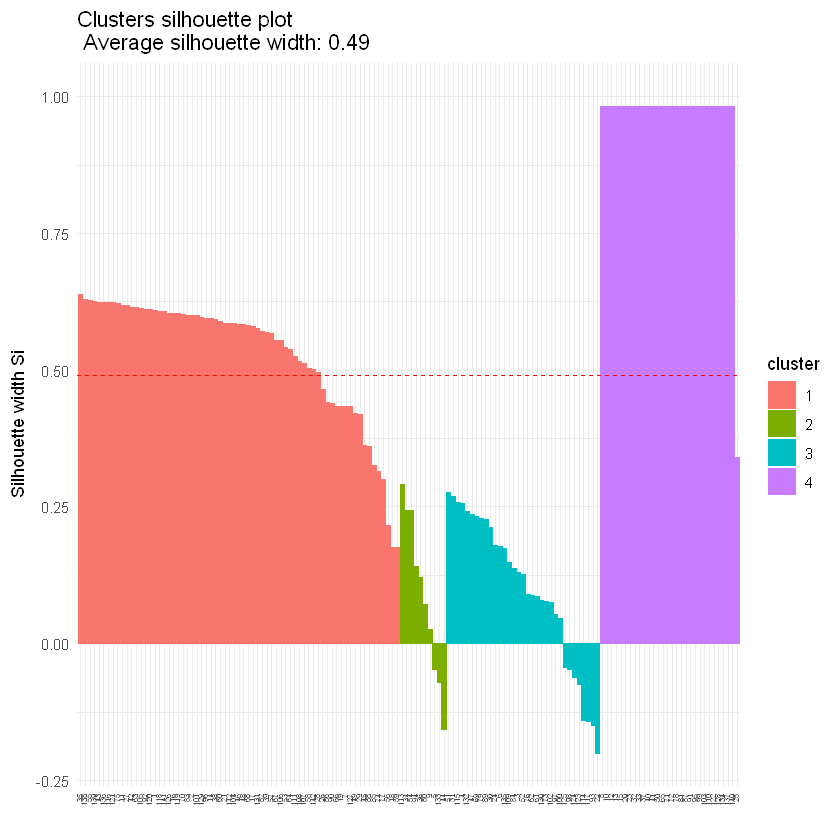

In [6]:
# ---- Silhouette Clusters
final_ss <- silhouette(km.res$cluster, dist(scaled))
ss <- fviz_silhouette(final_ss) + theme_minimal() + 
  theme(axis.text.x = element_text(angle = 90, vjust = 0.2, hjust=1, size=5)) 
ss

### 5 - Visualise Clusters
As the group sizes and scores look reasonable the clusters can now be visualised. To do this, the high dimensional data is projected onto 2 dimensions using PCA (taking the first two components). 

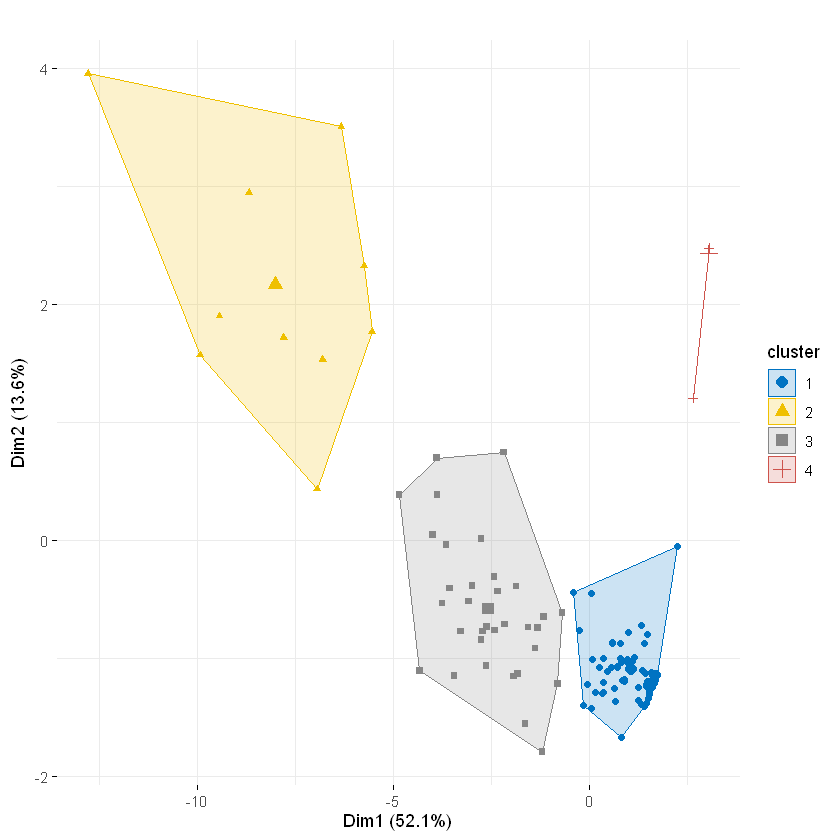

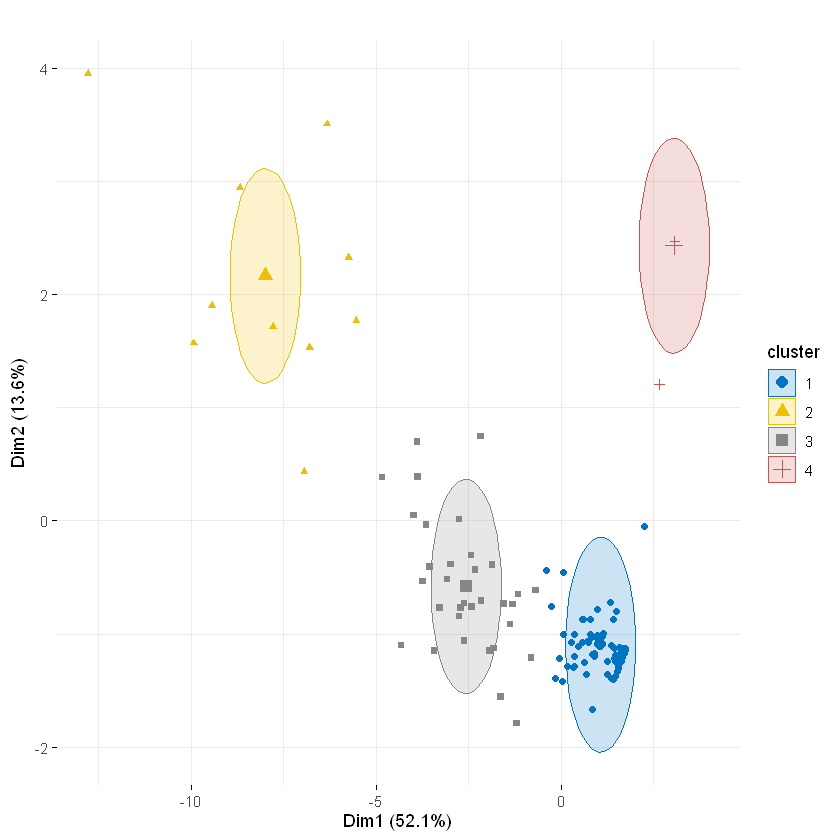

In [7]:
# To visualise the Edges of the cluster groups
cluster.edge <- fviz_cluster(object = km.res, 
                             data=scaled,
                             geom = "point",
                             palette = "jco",
                             main = "",
                             ggtheme = theme_minimal()) # Edges instead of Middle
cluster.edge

# To visualise the centres of the cluster groups
cluster <- fviz_cluster(object = km.res, # kmeans object 
                        data = scaled, # data used for clustering
                        ellipse.type = "euclid", # Elucid = see middle, Norm = see all points
                        geom = "point",
                        palette = "jco",
                        main = "",
                        ggtheme = theme_minimal())
cluster

#### All Silhouette Scores
The loop below will plot the Silhouette scores for all values of K so these could be visually assessed. 

  cluster size ave.sil.width
1       1   39          0.07
2       2  103          0.59
  cluster size ave.sil.width
1       1   80          0.45
2       2   30          0.96
3       3   32          0.03
  cluster size ave.sil.width
1       1   33          0.10
2       2   30          0.96
3       3   10          0.09
4       4   69          0.53
  cluster size ave.sil.width
1       1   29          0.11
2       2   24          0.11
3       3   50          0.59
4       4   30          0.96
5       5    9          0.11
  cluster size ave.sil.width
1       1   50          0.58
2       2   27          0.15
3       3    7          0.18
4       4   22          0.17
5       5    6         -0.01
6       6   30          0.96
  cluster size ave.sil.width
1       1    4          0.12
2       2   27          0.15
3       3    3          0.10
4       4   22          0.17
5       5   50          0.58
6       6    6          0.28
7       7   30          0.96
  cluster size ave.sil.width
1       1   30

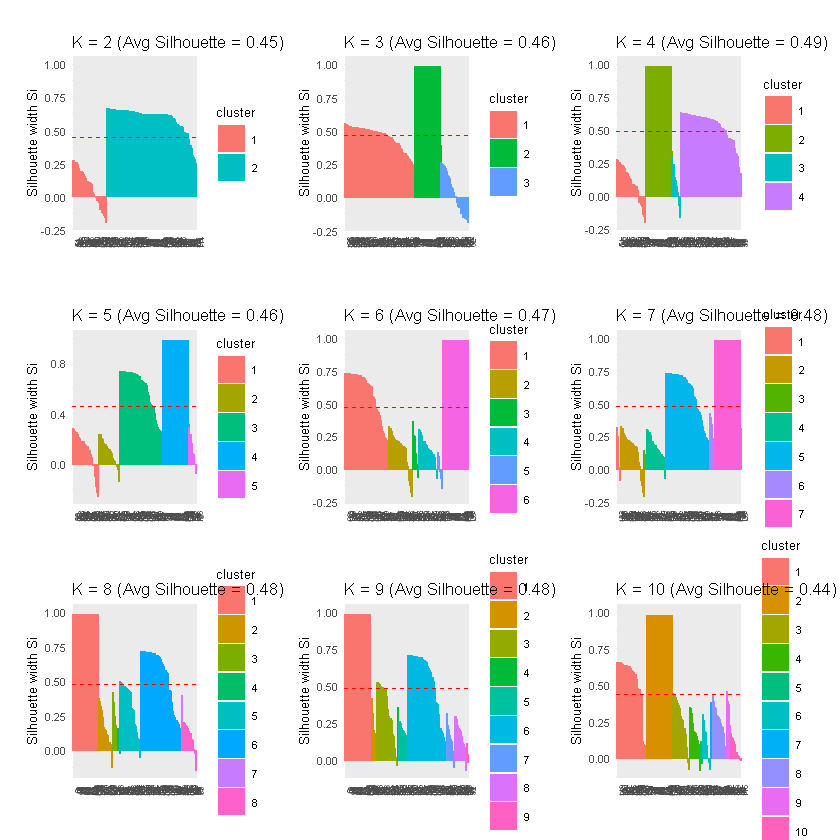

In [8]:
plots <- list()

for (k in 2:10) {
  # K-means clustering
  km.res <- kmeans(scaled, centers = k, nstart = 25)
  
  # Silhouette analysis
  sil <- silhouette(km.res$cluster, dist(scaled))
  avg_sil <- mean(sil[, "sil_width"])  # Compute average silhouette score
  
  # Silhouette plot with average score in title
  p <- fviz_silhouette(sil) +
    ggtitle(sprintf("K = %d (Avg Silhouette = %.2f)", k, avg_sil)) +
    theme_minimal(base_size = 8) +
    theme(axis.text.x = element_text(angle = 90, size = 5),
          plot.margin = margin(t = 15, r = 10, b = 10, l = 10),
          plot.title = element_text(size = 10))
  
  plots[[k - 1]] <- p
}

# Combine all plots
combined_plot <- wrap_plots(plots, ncol = 3)
combined_plot